In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import emoji
import nltk

from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from transformers import BertTokenizerFast, TFBertModel, RobertaTokenizerFast, TFRobertaModel
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras

In [2]:
df_train=pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv",encoding='ISO-8859-1')
df_test=pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv")

In [3]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [5]:
df_train['TweetAt']=pd.to_datetime(df_train['TweetAt'],dayfirst=True)

In [6]:
df_train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",2020-04-14,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,2020-04-14,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,2020-04-14,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,2020-04-14,Is it wrong that the smell of hand sanitizer i...,Neutral


In [7]:
df_train.drop_duplicates(subset='OriginalTweet',inplace=True)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


In [9]:
tweets_per_country = df_train['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

In [10]:
tweets_per_country

,Location,counts
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


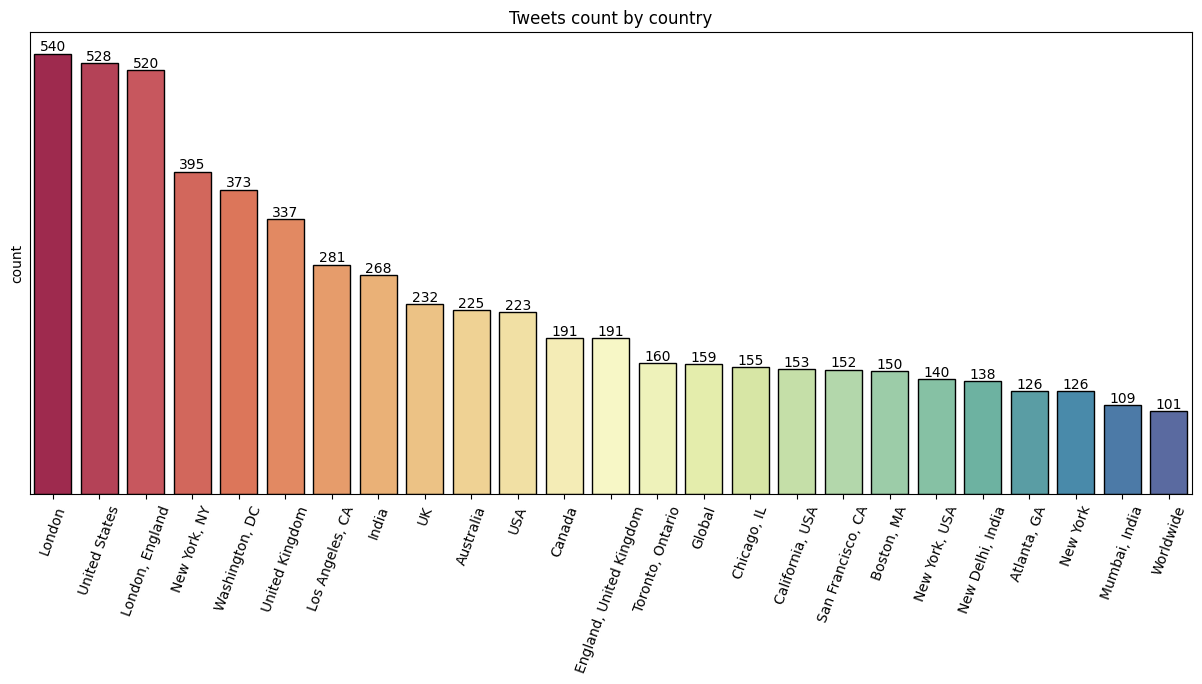

In [11]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x='Location', y='counts', data=tweets_per_country,edgecolor = 'black', palette='Spectral')
plt.title('Tweets count by country')
plt.xticks(rotation=70)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [12]:
df_train=df_train[['OriginalTweet','Sentiment']]

In [13]:
df_test=df_test[['OriginalTweet','Sentiment']]

In [14]:
def strip_emoji(text):
    if hasattr(emoji,'get_emoji_regexp'):
        return re.sub(emoji.get_emoji_regexp(),r"",text)
    else:
        return text

def strip_all(text):
    text=text.replace('\r','').replace('\n',' ').replace('\n',' ').lower()
    text=re.sub(r"(?:\@|https?\://)\S+",'',text)
    text=re.sub(r'[^\x00-\x7f]',r'',text)
    banned=string.punctuation+'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table=str.maketrans('','',banned)
    text=text.translate(table)
    return text

def clean_hashtags(tweet):
    new_tweet=' '.join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2=' '.join(word.strip() for word in re.split('#|_',new_tweet))
    return new_tweet2

def filter_chars(w):
    sent=[]
    for i in w.split(' '):
        if '$' in i or '&' in i:
            sent.append('')
        else:
            sent.append(i)
    return ' '.join(sent)

def remove_mult_space(text):
    return re.sub('\s\s+',' ',text)

In [15]:
texts_new_train=[]
for t in df_train.OriginalTweet:
    texts_new_train.append(remove_mult_space(filter_chars(clean_hashtags(strip_all(strip_emoji(t))))))

In [16]:
texts_new_test=[]
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_space(filter_chars(clean_hashtags(strip_all(strip_emoji(t))))))

In [17]:
df_train.loc[:,'text_clean']=texts_new_train
df_test.loc[:,'text_clean']=texts_new_test

/tmp/ipykernel_30/165357586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:,'text_clean']=texts_new_train


In [18]:
df_train['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

In [19]:
text_len_train=[]
for text in df_train.text_clean:
    tweet_len=len(text.split())
    text_len_train.append(tweet_len)

In [20]:
df_train.loc[:,'text_len']=text_len_train

/tmp/ipykernel_30/3492291159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:,'text_len']=text_len_train


In [21]:
text_len_test=[]
for text in df_test.text_clean:
    tweet_len=len(text.split())
    text_len_test.append(tweet_len)

In [22]:
df_test.loc[:,'text_len']=text_len_test

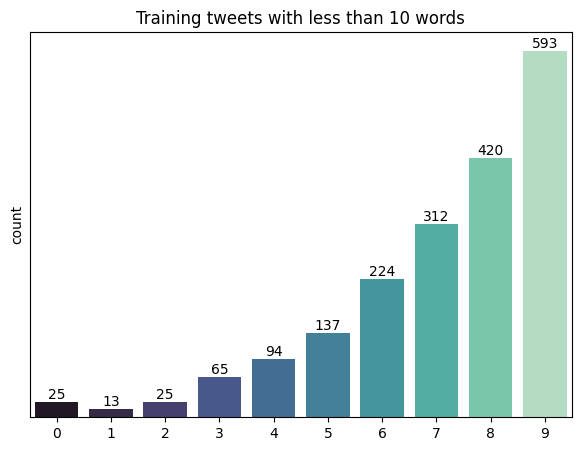

In [23]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_train[df_train['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

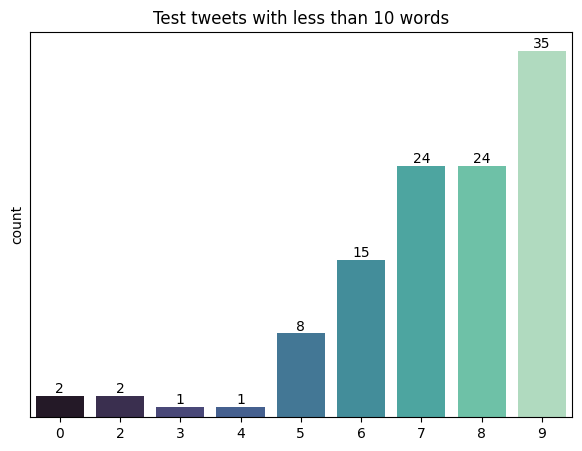

In [24]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [25]:
df_train.shape,df_test.shape

((41157, 4), (3798, 4))

In [26]:
df_train=df_train[df_train['text_len']>4]

In [27]:
df_test=df_test[df_test['text_len']>4]

In [28]:
df_train.shape,df_test.shape

((40935, 4), (3792, 4))

In [29]:
tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased',clean_up_tokenization_spaces=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [30]:
token_lens=[]
for txt in df_train['text_clean'].values:
    tokens=tokenizer.encode(txt,max_length=512,truncation=True)
    token_lens.append(len(tokens))
max_len=np.max(token_lens)

In [31]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 100


In [32]:
token_lens=[]
for i,txt in enumerate(df_train['text_clean'].values):
    tokens=tokenizer.encode(txt,max_length=512,truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"Index: {i}, Text: {txt}")

Index: 1622, Text: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
Index: 13623, Text: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
Index: 16548, Text: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
Index: 36953, Text: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededi

In [33]:
df_train.loc[:,'token_lens']=token_lens

In [34]:
df_train=df_train.sort_values(by='token_lens',ascending=False)
df_train.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,84
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,80
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,na wer war denn da am werk gestern nachmittag ...,37,80
27005,Supermercados Econo confirman que un empleado ...,Neutral,supermercados econo confirman que un empleado ...,39,80
11213,Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...,Negative,keine wertgegenstnde im fahrzeug lassen diesen...,33,79
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,79
18913,#CroozefmNews \r\r\nPresident Museveni has ord...,Extremely Negative,croozefmnews president museveni has ordered th...,35,79


In [35]:
df_train=df_train.iloc[12:]
df_train.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
8730,?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler...,Negative,bitte anschauen 12 emotionaler aufruf von geha...,36,77
12389,"Okay, so I just checked the drug prices for #P...",Positive,okay so i just checked the drug prices for pla...,35,77
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,47,77
1697,I work at a grocery store.\r\r\nWe wont get an...,Positive,i work at a grocery store we wont get any toil...,37,77
36305,Sterile disposable anti bacterial wet wipes an...,Negative,sterile disposable anti bacterial wet wipes an...,31,76


In [36]:
df_train=df_train.sample(frac=1).reset_index(drop=True)

In [37]:
token_lens_test=[]
for txt in df_test['text_clean'].values:
    tokens=tokenizer.encode(txt,max_length=512,truncation=True)
    token_lens_test.append(len(tokens))
max_len=np.max(token_lens_test)

In [38]:
print(f"Max Tokenize Sentence Length: {max_len}")

Max Tokenize Sentence Length: 96


In [39]:
token_lens_test=[]
for i,txt in enumerate(df_test['text_clean'].values):
    tokens=tokenizer.encode(txt,max_length=512,truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"Index: {i}, Text: {txt}")

Index: 286, Text: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
Index: 345, Text: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
Index: 2380, Text: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


In [40]:
df_test.loc[:,'token_lens']=token_lens_test

In [41]:
df_test=df_test.sort_values(by='token_lens',ascending=False)
df_test.head(10)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,96
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,77
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,74
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70


In [42]:
df_test=df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70


In [43]:
df_test=df_test.sample(frac=1).reset_index(drop=True)

In [44]:
df_train['Sentiment'].value_counts()

Sentiment
Positive              11381
Negative               9889
Neutral                7560
Extremely Positive     6618
Extremely Negative     5475
Name: count, dtype: int64

In [45]:
df_train['Sentiment']=df_train['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [46]:
df_test['Sentiment']=df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [47]:
df_train['Sentiment'].value_counts()

Sentiment
2    17999
0    15364
1     7560
Name: count, dtype: int64

In [48]:
ros=RandomOverSampler()
X_train,Y_train=ros.fit_resample(np.array(df_train['text_clean']).reshape(-1,1),np.array(df_train['Sentiment']).reshape(-1,1))
train_os=pd.DataFrame(list(zip([x[0] for x in X_train],Y_train)),columns=['text_clean','Sentiment'])

In [49]:
train_os['Sentiment'].value_counts()

Sentiment
2    17999
0    17999
1    17999
Name: count, dtype: int64

In [50]:
X=train_os['text_clean'].values
Y=train_os['Sentiment'].values

In [51]:
X_train,X_valid, Y_train,Y_valid=train_test_split(X,Y,test_size=0.1,stratify=Y,random_state=42)

In [52]:
X_test=df_test['text_clean'].values
Y_test=df_test['Sentiment'].values

In [53]:
Y_train_le=Y_train.copy()
Y_valid_le=Y_valid.copy()
Y_test_le=Y_test.copy()

In [54]:
ohe=OneHotEncoder()
Y_train=ohe.fit_transform(np.array(Y_train).reshape(-1,1)).toarray()
Y_valid=ohe.fit_transform(np.array(Y_valid).reshape(-1,1)).toarray()
Y_test=ohe.fit_transform(np.array(Y_test).reshape(-1,1)).toarray()

In [55]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48597
VALIDATION DATA: 5400
TESTING DATA: 3787


In [56]:
clf=CountVectorizer()
X_train_cv=clf.fit_transform(X_train)
X_test_cv=clf.transform(X_test)

In [57]:
X_train_cv.shape,X_test_cv.shape

((48597, 48520), (3787, 48520))

In [58]:
tf_transformer=TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf=tf_transformer.transform(X_train_cv)
X_test_tf=tf_transformer.transform(X_test_cv)

In [59]:
nb_clf=MultinomialNB()

In [60]:
nb_clf.fit(X_train_tf,Y_train_le)

MultinomialNB()

In [61]:
nb_pred=nb_clf.predict(X_test_tf)

In [62]:
print(classification_report(Y_test_le,nb_pred))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1629
           1       0.60      0.45      0.51       614
           2       0.74      0.72      0.73      1544

    accuracy                           0.71      3787
   macro avg       0.68      0.65      0.66      3787
weighted avg       0.70      0.71      0.70      3787



In [63]:
MAX_LEN=128

In [64]:
def tokenize(data,max_len=MAX_LEN):
    input_ids=[]
    attention_masks=[]
    for i in range(len(data)):
        encoded=tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [65]:
train_input_ids,train_attention_masks=tokenize(X_train,MAX_LEN)
val_input_ids,val_attention_masks=tokenize(X_valid,MAX_LEN)
test_input_ids,test_attention_masks=tokenize(X_test,MAX_LEN)

In [66]:
bert_model=TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [67]:
def create_model(bert_model,max_len=MAX_LEN):
    opt=tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss=tf.keras.losses.CategoricalCrossentropy()
    accuracy=tf.keras.metrics.CategoricalAccuracy()
    input_ids=tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks=tf.keras.Input(shape=(max_len,),dtype='int32')
    embeddings=bert_model([input_ids,attention_masks])[1]
    output=tf.keras.layers.Dense(3,activation='softmax')(embeddings)
    model=tf.keras.models.Model(inputs=[input_ids,attention_masks],outputs=output)
    model.compile(opt,loss=loss,metrics=accuracy)
    return model

In [68]:
model=create_model(bert_model,MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [69]:
history_bert=model.fit([train_input_ids,train_attention_masks],Y_train,validation_data=([val_input_ids,val_attention_masks],Y_valid),epochs=4,batch_size=32)

Epoch 1/4


I0000 00:00:1729763614.909598     106 service.cc:145] XLA service 0x7b31c83d6210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729763614.909655     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729763615.088180     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1519/1519 [==============================] - 818s 492ms/step - loss: 0.5548 - categorical_accuracy: 0.7768 - val_loss: 0.3248 - val_categorical_accuracy: 0.8846
Epoch 2/4
1519/1519 [==============================] - 736s 485ms/step - loss: 0.2846 - categorical_accuracy: 0.8998 - val_loss: 0.2615 - val_categorical_accuracy: 0.9065
Epoch 3/4
1519/1519 [==============================] - 736s 485ms/step - loss: 0.1934 - categorical_accuracy: 0.9329 - val_loss: 0.2358 - val_categorical_accuracy: 0.9174
Epoch 4/4
1519/1519 [==============================] - 736s 485ms/step - loss: 0.1359 - categorical_accuracy: 0.9539 - val_loss: 0.2442 - val_categorical_accuracy: 0.9302


In [70]:
result_bert=model.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 30s 162ms/step


In [71]:
Y_pred_bert=np.zeros_like(result_bert)
Y_pred_bert[np.arange(len(Y_pred_bert)),result_bert.argmax(1)]=1

In [72]:
confusion_matrix(Y_test.argmax(1),Y_pred_bert.argmax(1))

array([[1502,   38,   89],
       [  90,  476,   48],
       [ 143,   34, 1367]])

In [73]:
print(classification_report(Y_test,Y_pred_bert))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1629
           1       0.87      0.78      0.82       614
           2       0.91      0.89      0.90      1544

   micro avg       0.88      0.88      0.88      3787
   macro avg       0.88      0.86      0.87      3787
weighted avg       0.88      0.88      0.88      3787
 samples avg       0.88      0.88      0.88      3787



In [76]:
tokenizer_roberta=RobertaTokenizerFast.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [77]:
token_lens=[]
for txt in X_train:
    tokens=tokenizer_roberta.encode(txt,max_length=512,truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

89

In [78]:
MAX_LEN=128

In [81]:
def tokenize_roberta(data,max_len=MAX_LEN):
    input_ids=[]
    attention_masks=[]
    for i in range(len(data)):
        encoded=tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [82]:
train_input_ids,train_attention_masks=tokenize_roberta(X_train,MAX_LEN)
val_input_ids,val_attention_masks=tokenize_roberta(X_valid,MAX_LEN)
test_input_ids,test_attention_masks=tokenize_roberta(X_test,MAX_LEN)

In [83]:
def create_model(bert_model, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [84]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [85]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_3[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_4[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

In [87]:
history_2 = model.fit([train_input_ids,train_attention_masks], Y_train, validation_data=([val_input_ids,val_attention_masks], Y_valid), epochs=4, batch_size=30)

Epoch 1/4
1620/1620 [==============================] - 826s 475ms/step - loss: 0.5609 - categorical_accuracy: 0.7782 - val_loss: 0.3545 - val_categorical_accuracy: 0.8730
Epoch 2/4
1620/1620 [==============================] - 758s 468ms/step - loss: 0.3298 - categorical_accuracy: 0.8824 - val_loss: 0.3168 - val_categorical_accuracy: 0.8913
Epoch 3/4
1620/1620 [==============================] - 759s 468ms/step - loss: 0.2481 - categorical_accuracy: 0.9122 - val_loss: 0.2589 - val_categorical_accuracy: 0.9133
Epoch 4/4
1620/1620 [==============================] - 759s 468ms/step - loss: 0.1942 - categorical_accuracy: 0.9310 - val_loss: 0.2504 - val_categorical_accuracy: 0.9241


In [88]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 30s 163ms/step


In [91]:
Y_pred_roberta =  np.zeros_like(result_roberta)
Y_pred_roberta[np.arange(len(Y_pred_roberta)), result_roberta.argmax(1)] = 1

In [92]:
confusion_matrix(Y_test.argmax(1),Y_pred_roberta.argmax(1))

array([[1481,   77,   71],
       [  71,  504,   39],
       [ 116,   81, 1347]])

In [93]:
print(classification_report(Y_test,Y_pred_roberta))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1629
           1       0.76      0.82      0.79       614
           2       0.92      0.87      0.90      1544

   micro avg       0.88      0.88      0.88      3787
   macro avg       0.86      0.87      0.86      3787
weighted avg       0.88      0.88      0.88      3787
 samples avg       0.88      0.88      0.88      3787



In [94]:
print(classification_report(Y_test,Y_pred_bert))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1629
           1       0.87      0.78      0.82       614
           2       0.91      0.89      0.90      1544

   micro avg       0.88      0.88      0.88      3787
   macro avg       0.88      0.86      0.87      3787
weighted avg       0.88      0.88      0.88      3787
 samples avg       0.88      0.88      0.88      3787



In [95]:
print(classification_report(Y_test,Y_pred_roberta))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1629
           1       0.76      0.82      0.79       614
           2       0.92      0.87      0.90      1544

   micro avg       0.88      0.88      0.88      3787
   macro avg       0.86      0.87      0.86      3787
weighted avg       0.88      0.88      0.88      3787
 samples avg       0.88      0.88      0.88      3787

